In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as optimize
from scipy.stats import linregress
import matplotlib as mpl
import pandas as pd

In [2]:
def linear_fit(x, y, yerr):
    x = np.copy(x)
    y = np.copy(y)
    #https://q.utoronto.ca/courses/363859/files/32966656?module_item_id=6010287
    delta = len(x) * sum(x**2) - sum(x)**2
    m = (len(x) * sum(x*y) - sum(x) * sum(y)) / delta
    b = (sum(y) - m * sum(x)) / len(x)
    
    y_var_2 = ((1/ (len(x) - 2)) * sum((y - (b + m * x))**2))
    m_std = (y_var_2 * (len(x) / delta))**0.5
    b_std = (y_var_2 * (sum(x**2) / delta))**0.5
    
    r_2 = 1 - (len(x)-2) * y_var_2 / sum((y - np.mean(y))**2)
    
    chi_2 = sum((( y - (b + m * x)))**2 / yerr)
    reduced_chi_2 = chi_2 / (len(y) - 2)
    std_residuals = (sum((y - (b + m * x)) ** 2 ) / (len(x) - 2)) ** 0.5
        
    
    return (m, b, m_std, b_std, r_2, chi_2, reduced_chi_2, std_residuals)

In [95]:
def residual_plot(x, y, x_err, y_err, m, b, title, xlabel, ylabel, filename="residuals"):
    # Calculate residuals
    y_fit = m * x + b
    residuals = y - y_fit
    
    # Create residual plot
    plt.figure(figsize=(8,6))
    plt.scatter(x, residuals, c='blue', marker='o')
    plt.axhline(y=0, color='r', linestyle='-')
    
    # Add error bars to residuals with both x and y uncertainties
    plt.errorbar(x, residuals, xerr=x_err, yerr=y_err, fmt='none', capsize=5, color='blue')
    
    # Labels and title
    plt.xlabel(xlabel)
    plt.ylabel(f"Residuals ({ylabel})")
    plt.title(f"Residuals Plot: {title}")
    plt.grid(True)
    
    # Save and show plot
    plt.savefig(f'{filename}.png')
    plt.show()


In [27]:
def plot(x, y, x_err, y_err, m, b, title, xlabel, ylabel, filename="graph"):
    # Plot the data
    plt.figure(figsize=(8,6))
    plt.errorbar(x, y, xerr=(x_err), yerr=y_err, 
                fmt='o', label='Data points', capsize=5)
    plt.plot(x, m * x + b, 'r-', label=f'Best Fit: y = {m:.3e}x + {b:.3e}')

    # Labels and title
    plt.xlabel(ylabel)
    plt.ylabel(xlabel)
    plt.title(title)
    plt.legend()
    plt.grid()

    # Show the plot
    plt.savefig(f'{filename}.png')
    plt.show()

In [123]:
COIL_RADIUS=31.5 / 2 / 100
RADIUS_ERROR=0.05 / 100
NUMBER_OF_TURNS=130
I_ERROR=0.005
V_ERROR = 0.1
mu_0 = 4 * np.pi * 10**-7
k = 1/np.sqrt(2) * (4/5)**(3/2) * mu_0 * NUMBER_OF_TURNS / COIL_RADIUS
K_ERROR = k * (RADIUS_ERROR / COIL_RADIUS)

def B_field(I):
    return (4/5)**(3/2) * (mu_0 * NUMBER_OF_TURNS * I) / COIL_RADIUS

def B_field_error(I):
    return B_field(I) * np.sqrt((I_ERROR / I)**2 + (RADIUS_ERROR / COIL_RADIUS)**2)



In [92]:
df = pd.read_csv("fixed_voltage.csv")

df2 = pd.read_csv("fixed_current.csv")
df_all = pd.concat([df, df2], ignore_index=True)

def B_corrected(I, rho):
    return B_field(I) / (1 - rho ** 4 / (COIL_RADIUS ** 4 * (0.6583 + 0.29 * rho ** 2 / COIL_RADIUS ** 2) ** 2))

def add_columns(df):
    df['Mean_Diameter'] = df[['Diameter 1', 'Diameter 2', 'Diameter 3', 'Diameter 4']].mean(axis=1)
    df['Mean_Diameter_Error'] = df[['Diameter 1', 'Diameter 2', 'Diameter 3', 'Diameter 4']].std(axis=1)
    df['Mean_Radius'] = df['Mean_Diameter'] / 2 / 100
    df['Mean_Radius_Error'] = df['Mean_Diameter_Error'] / 2 / 100
    df = df.drop(['Mean_Diameter', 'Mean_Diameter_Error'], axis=1)
    df['B_c'] = df['Current'].apply(B_field)
    df['B_c_Error'] = df['Current'].apply(B_field_error) 
    # df['B_c'] = df['B_c'] * 1e6
    # df['B_c_Error'] = df['B_c_Error'] * 1e6

    df['B_corrected'] = df['B_corrected'] = df.apply(lambda row: B_corrected(row['Current'], row['Mean_Radius']), axis=1)
    return df

df = add_columns(df)
df_all = add_columns(df_all)

df

,Voltage,Current,Diameter 1,Diameter 2,Diameter 3,Diameter 4,Mean_Radius,Mean_Radius_Error,B_c,B_c_Error,B_corrected
0,107,0.885,9.3,9.2,9.1,9.2,0.046000,0.000408,0.000657,0.000004,0.000667
1,107,1.018,7.8,7.9,7.9,8.1,0.039625,0.000629,0.000756,0.000004,0.000762
2,107,1.181,6.7,6.7,6.8,6.7,0.033625,0.000250,0.000877,0.000005,0.000881
3,107,1.339,6.0,6.1,6.0,6.0,0.030125,0.000250,0.000994,0.000005,0.000997
4,107,1.462,5.5,5.5,5.5,5.8,0.027875,0.000750,0.001085,0.000005,0.001087
5,107,1.729,4.8,5.1,4.9,5.0,0.024750,0.000645,0.001283,0.000006,0.001285
6,107,1.853,4.5,4.4,4.5,4.4,0.022250,0.000289,0.001375,0.000006,0.001376
7,107,1.932,4.3,4.3,4.4,4.2,0.021500,0.000408,0.001434,0.000006,0.001435


Slope: 3.177e-05 ± 9.685e-07
Y-intercept: -4.137e-05 ± 3.458e-05
R^2: 0.994456
Chi^2: 0.001
Reduced chi^2: 0.000


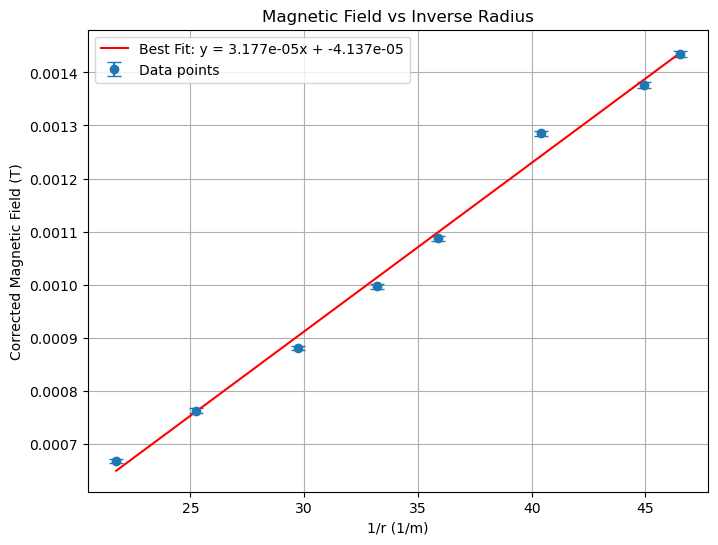

In [130]:
#Corrected B_c vs 1/r

# Convert B_c and error to numpy arrays
B_c = df['B_corrected'].to_numpy()
B_c_error = df['B_c_Error'].to_numpy()

# Calculate inverse radius and propagate uncertainty
inv_radius = 1 / df['Mean_Radius'].to_numpy()
inv_radius_error = df['Mean_Radius_Error'].to_numpy() / (df['Mean_Radius'].to_numpy())**2

# Fit and plot B_c vs 1/r
m, b, m_std, b_std, r_2, chi_2, reduced_chi_2, std_residuals = linear_fit(
    inv_radius,
    B_c,
    B_c_error
)

print(f"Slope: {m:.3e} ± {m_std:.3e}")
print(f"Y-intercept: {b:.3e} ± {b_std:.3e}") 
print(f"R^2: {r_2:.6f}")
print(f"Chi^2: {chi_2:.3f}")
print(f"Reduced chi^2: {reduced_chi_2:.3f}")

plot(
    inv_radius,
    B_c,
    None,
    B_c_error,
    m, b,
    "Magnetic Field vs Inverse Radius",
    "Corrected Magnetic Field (T)",
    "1/r (1/m)",
    "b_field_vs_inverse_radius"
)

B_e = -b
B_e_error = b_std
e_m_ratio_1 = 2 * 107 / m ** 2
e_m_ratio_1_error = 2 * 107 / m ** 2 * m_std

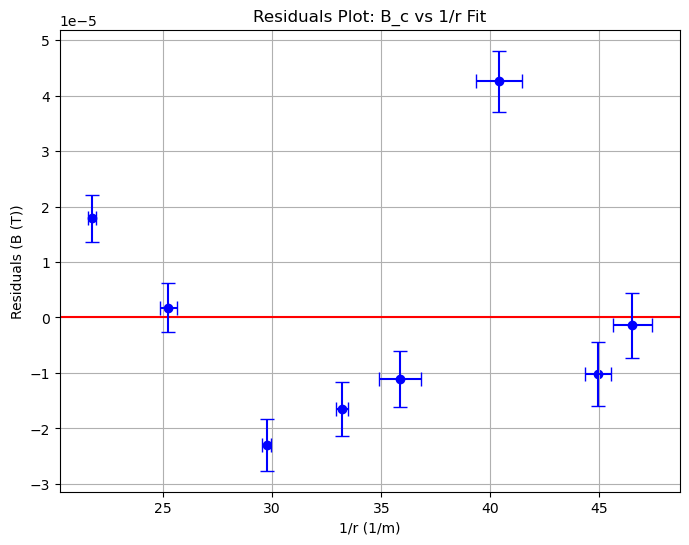

In [99]:
#x, y, m, b, title, xlabel, ylabel, filename="residuals"
residual_plot(
    inv_radius,
    B_c,
    inv_radius_error,
    B_c_error,
    m,
    b,
    "B_c vs 1/r Fit",
    "1/r (1/m)",
    "B (T)",
    "residuals_b_field_vs_inverse_radius"
)

In [155]:
#sqrt V / k(I + 1/sqrt 2 * I_0) vs r
def func(V, I, B_e):
    return np.sqrt(V) / (k * (I + 1/np.sqrt(2) * B_e / k))

I_o_error = B_e / k * np.sqrt((B_e_error / B_e)**2 + (K_ERROR / k)**2)

def func_error(V, I, B_e):
    t = func(V, I, B_e)
    return np.sqrt((t / 2 / V * V_ERROR)**2 + (t / k * K_ERROR)**2 + (t ** 2 * k / np.sqrt(V) * I_ERROR)**2 + (t**2 * k / np.sqrt(2 *V) * I_o_error)**2)

df_all['term'] = df_all.apply(lambda row: func(row['Voltage'], row['Current'], B_e), axis=1)
df_all['term_error'] = df_all.apply(lambda row: func_error(row['Voltage'], row['Current'], B_e), axis=1)

print(I_ERROR, I_o_error)
print((B_e_error / B_e)**2, (K_ERROR / k)**2, np.sqrt((B_e_error / B_e)**2 + (K_ERROR / k)**2))
df_all

0.005 0.06589193732260508
0.6986763975831498 1.0078105316200555e-05 0.8358746770230966


,Voltage,Current,Diameter 1,Diameter 2,Diameter 3,Diameter 4,Mean_Radius,Mean_Radius_Error,B_c,B_c_Error,B_corrected,term,term_error
0,107,0.885,9.3,9.2,9.1,9.2,0.046000,0.000408,0.000657,0.000004,0.000667,20952.174168,1045.831847
1,107,1.018,7.8,7.9,7.9,8.1,0.039625,0.000629,0.000756,0.000004,0.000762,18356.912636,803.293883
2,107,1.181,6.7,6.7,6.8,6.7,0.033625,0.000250,0.000877,0.000005,0.000881,15937.508460,606.034157
3,107,1.339,6.0,6.1,6.0,6.0,0.030125,0.000250,0.000994,0.000005,0.000997,14132.064996,476.965999
4,107,1.462,5.5,5.5,5.5,5.8,0.027875,0.000750,0.001085,0.000005,0.001087,12986.781449,403.125612
5,107,1.729,4.8,5.1,4.9,5.0,0.024750,0.000645,0.001283,0.000006,0.001285,11043.939150,292.127033
6,107,1.853,4.5,4.4,4.5,4.4,0.022250,0.000289,0.001375,0.000006,0.001376,10326.477572,255.674333
7,107,1.932,4.3,4.3,4.4,4.2,0.021500,0.000408,0.001434,0.000006,0.001435,9916.066126,235.922570
8,80,1.391,4.8,4.6,4.7,4.6,0.023375,0.000479,0.001032,0.000005,0.001034,11780.439984,383.469147
9,105,1.391,5.6,5.8,5.7,5.7,0.028500,0.000408,0.001032,0.000005,0.001035,13496.189487,439.285127


Slope: 4.354e+05 ± 9.818e+03
Y-intercept: 8.854e+02 ± 3.393e+02
R^2: 0.992932
Chi^2: 4041.973
Reduced chi^2: 288.712


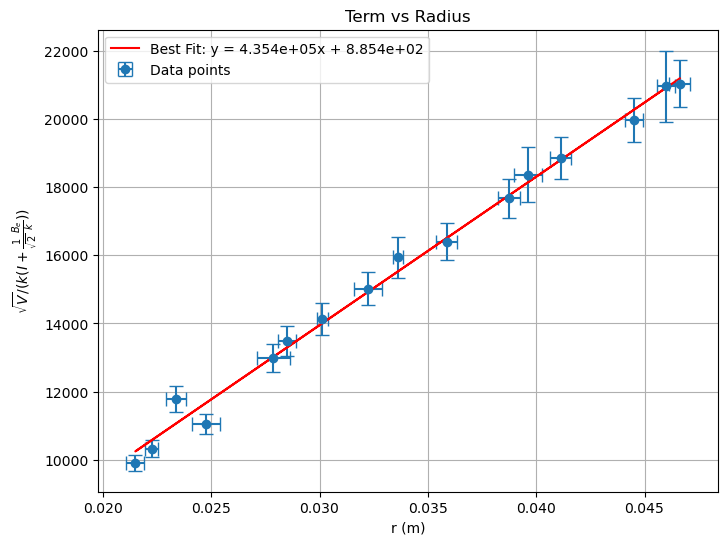

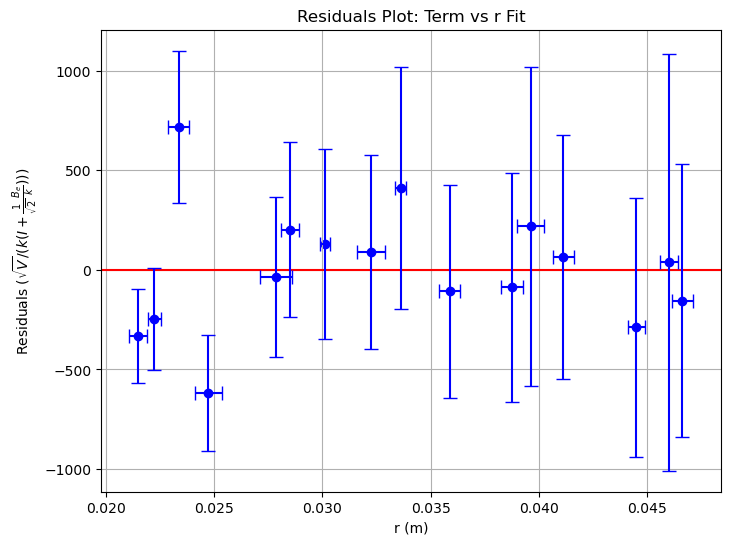

In [156]:
m, b, m_std, b_std, r_2, chi_2, reduced_chi_2, std_residuals = linear_fit(
    df_all['Mean_Radius'],
    df_all['term'],
    df_all['term_error']
)

print(f"Slope: {m:.3e} ± {m_std:.3e}")
print(f"Y-intercept: {b:.3e} ± {b_std:.3e}") 
print(f"R^2: {r_2:.6f}")
print(f"Chi^2: {chi_2:.3f}")
print(f"Reduced chi^2: {reduced_chi_2:.3f}")

plot(
    df_all['Mean_Radius'],
    df_all['term'],
    df_all['Mean_Radius_Error'],
    df_all['term_error'],
    m, b,
    "Term vs Radius",
    "$\\sqrt{V}/(k(I + \\frac{1}{\\sqrt{2}}\\frac{B_e}{k}))$",
    "r (m)",
    "term_vs_inverse_radius"
)

residual_plot(
    df_all['Mean_Radius'],
    df_all['term'],
    df_all['Mean_Radius_Error'],
    df_all['term_error'],
    m, b,
    "Term vs r Fit",
    "r (m)",
    "$\\sqrt{V}/(k(I + \\frac{1}{\\sqrt{2}}\\frac{B_e}{k}))$",
    "residuals_term_vs_inverse_radius"
)

e_m_ratio = m ** 2
e_m_ratio_error = 2 * m * m_std

In [149]:
print(f"e/m ratio: {e_m_ratio:.3e} ± {e_m_ratio_error:.3e}")
print(f"{e_m_ratio - e_m_ratio_error:.3e} to {e_m_ratio + e_m_ratio_error:.3e}")
# print(f"e/m ratio from B_c plot: {e_m_ratio_1:.3e} ± {e_m_ratio_1_error:.3e}")


e/m ratio: 1.896e+11 ± 8.550e+09
1.810e+11 to 1.981e+11
